In [5]:
import requests
import json
import pandas as pd
import numpy as np
import datetime
from dateutil.tz import gettz
from scipy.signal import argrelextrema

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import time

In [35]:
def read_data(devid, address, start_time, end_time, descriptors):

    r = requests.post(address + "/api/auth/login",
                      json={'username': 'tenant@thingsboard.org', 'password': 'tenant'}).json()

    # acc_token is the token to be used in the next request
    acc_token = 'Bearer' + ' ' + r['token']
    
    r2 = requests.get(
        url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=" + descriptors + "&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

    if r2:
        df = pd.DataFrame([])

        for desc in r2.keys():
            df1 = pd.DataFrame(r2[desc])
            df1.set_index('ts', inplace=True)
            df1.columns = [str(desc)]
            
            df1.reset_index(drop=False, inplace=True)
            df1['ts'] = pd.to_datetime(df1['ts'], unit='ms')
            df1['ts'] = df1['ts'].dt.tz_localize('utc').dt.tz_convert('Europe/Athens')
            df1 = df1.sort_values(by=['ts'])
            df1.reset_index(drop=True, inplace=True)
            df1.set_index('ts', inplace=True, drop=True)            
            
            df = pd.concat([df, df1], axis=1)

        if df.empty:
            df = pd.DataFrame([])
        else:
            for col in df.columns:
                df[col] = df[col].astype('float64')
    else:
        df = pd.DataFrame([])
        print('Empty json!')
    return df


def identify_events(df, interval):
    # Run dataframe row by row to identify start of each event

    ind=0
    df['ind'] = np.nan
    event = 0
    thres = 3*interval+1
    for i in range(0, int(df.shape[0]-2)):
        if  event==0:
            # start of event
            if (df['dif'].iloc[i]>thres and df['dif'].iloc[i+1]>thres and df['dif'].iloc[i+2]<=thres):
                event=1
                df['ind'].iloc[i] = int(ind)

        elif event==1:
            # end of event
            if (df['dif'].iloc[i]>thres and df['dif'].iloc[i-1]<thres):
                df['ind'].iloc[i] = int(ind)
                event = 0
                ind += 1
            else:
                df['ind'].iloc[i] = int(ind)
    df = df.dropna()
    return df



def detect_appliance(df, interval):
    half = 10 # sliding length
    # interval = int(50) #fast pace frequency, every 50msec
    sec = 1000/interval # number of samples per second
    events = []
    deltas = {} #delta Power ON
    deltasre = {} #delta reactive Power ON
    offdeltas = {} #delta Power OFF
    offre = {} #delta reactive Power OFF
    d={}

    # iterate over groups to detect events
    for name, tmp1 in df.groupby('ind'):
        winlen = tmp1.shape[0]
        startPoint = int(tmp1['dif'].iloc[1]/interval-sec)
        endPoint = int(tmp1['dif'].iloc[-1]/interval-sec)
        
        # if the right edge of the event is too far, make it smaller
        if tmp1['dif'].iloc[-1]>120000:
            endPoint = int(tmp1['dif'].iloc[-1]/interval+2*sec)
        tmp1 = tmp1.resample(str(interval)+'ms').mean()
        
        # forward fill
        tmp1['pwrA'] = tmp1['pwrA'].fillna(method='ffill')
        tmp1['rpwrA'] = tmp1['rpwrA'].fillna(method='ffill')

        #check if there is a delta OFF based on head and tail of group
        deltaO = tmp1['pwrA'].iloc[-10:].mean() - tmp1['pwrA'].iloc[:10].mean()
        rdeltaO = tmp1['rpwrA'].iloc[-10:].mean() - tmp1['rpwrA'].iloc[:10].mean()
        if ((deltaO<-30) & (deltaO>-200)):
            offdeltas[tmp1.index[0]] = deltaO
            offre[tmp1.index[0]] = rdeltaO # reactive delta

        tmp1 = tmp1.iloc[startPoint:]
        tmp1 = tmp1.iloc[:-endPoint]


        # iterate within window to ensure the algorithm catches the event
        for k in range(0, int(tmp1.shape[0]/half)-int(winlen/half)):
            tmp = pd.DataFrame([])
            tmp = tmp1.iloc[k*half:k*half+winlen].copy()
            k+=1
            
            # calculate derivative and take 3 top local maxima
            tmp['extrema'] = 0
            tmp['der1'] = np.abs(tmp['pwrA'].shift(-1)-tmp['pwrA'].shift())

            tmp['extrema'] = tmp.iloc[argrelextrema(tmp['der1'].values, np.greater_equal,order=1)[0]]['der1']
            tmp.sort_values(by='extrema', ascending=False, inplace=True)
            tmp['extrema'][:3]=1
            tmp['extrema'][3:]=0

            tmp.sort_index(inplace=True)

            
            # split event in 4 parts and calculate avg power
            s=0
            n=0
            parts = []
            for j in range(0,tmp.shape[0]):
                if tmp['extrema'].iloc[j]<1:
                    n += 1
                    s += tmp['pwrA'].iloc[j]
                else:
                    n += 1
                    s += tmp['pwrA'].iloc[j]
                    parts.append(s/n)
                    n = 0
                    s = 0

            # check rules
            if n!=0:
                parts.append(s/n)
                if len(parts)>3:
                    pmin = 50
                    pmax = 700
                    rule1 = parts[3]-parts[0]>pmin
                    rule2 = parts[3]-parts[0]<pmax
                    rule3 = parts[2]-parts[0]>5*(parts[3]-parts[0])
                    rule4 = parts[1]-parts[0]>1.1*(parts[2]-parts[0])
                    if (rule1 and rule2 and rule3 and rule4):

                        hour = str(tmp.index.hour[0])+':'+str(tmp.index.minute[0])
                        if not hour in events:
                            deltaP = tmp['pwrA'].iloc[-10:].mean() - tmp['pwrA'].iloc[:10].mean()
                            deltaR = tmp['rpwrA'].iloc[-10:].mean() - tmp['rpwrA'].iloc[:10].mean()
                            deltas[tmp.index[0]] = deltaP
                            deltasre[tmp.index[0]] = deltaR # reactive

                            events.append(hour)
                            d[tmp.index[0]] = 1
#                             print('fridge ', hour)

    return offdeltas, offre, deltas, deltasre, d



def transform_dicts(offdeltas, offre, deltas, deltasre, d):
    # convert dictionaries to dataframes
    off = pd.DataFrame.from_dict(offdeltas, orient='index')
    off.rename(columns={0:'pwr'}, inplace=True)
    off_re = pd.DataFrame.from_dict(offre, orient='index')
    off_re.rename(columns={0:'rpwr'}, inplace=True)
    off = pd.concat([off,off_re], axis=1)

    dl = pd.DataFrame.from_dict(deltas, orient='index')
    dl.rename(columns={0:'pwr'}, inplace=True)
    dl_re = pd.DataFrame.from_dict(deltasre, orient='index')
    dl_re.rename(columns={0:'rpwr'}, inplace=True)
    dl = pd.concat([dl,dl_re], axis=1)


    fr = pd.DataFrame.from_dict(d, orient='index')
    
    del offdeltas,offre,deltas,deltasre,d
    return off, dl, fr


def eliminate_offs(dl,off):

    # define threshold for delta OFFs active power, based on average delta ONs
    up_thres = dl['pwr'].mean()
    down_thres = 0.7*up_thres
#     print(up_thres, down_thres)

    # define threshold for delta OFFs reactive power, based on average delta ONs
    up_thres_re = dl['rpwr'].mean()
    down_thres_re = 0.8*up_thres_re
    up_thres_re = up_thres_re + 0.01*up_thres_re 
#     print(up_thres_re, down_thres_re)

    # keep only OFF events that lie between thresholds

    off = off.loc[(off['pwr']>-up_thres) & (off['pwr']<-down_thres) & (off['rpwr']>-up_thres_re) & (off['rpwr']<-down_thres_re)]
    off['pwr'] = off['pwr']*(-1)
    off['rpwr'] = off['rpwr']*(-1)
    
    return off


def estimate_duration(df, fr, off):


    # concatenate all information to a df to plot results 

    df2 = pd.concat([df,fr], axis=1)
    df2.rename(columns={0:'fridge'}, inplace=True)
    df2 = pd.concat([df2,off['pwr']], axis=1)
    df2.rename(columns={'pwr':'deltaoff'}, inplace=True)

    df2.loc[df2['fridge']!=1, 'fridge'] = 0

    df2 = df2[['pwrA','fridge', 'deltaoff']]
    df2['pwrA'].fillna(method='bfill', inplace=True)
    df2['deltaoff'].fillna(value=0, inplace=True)

    # create onoff df to calculate duration between on/off
    onoff = pd.DataFrame([])
    onoff = pd.concat([onoff,df2[['pwrA','deltaoff','fridge']]], axis=1)
    onoff['rule'] = np.nan
    onoff.loc[onoff['fridge']>0, 'rule'] = 1
    onoff.loc[onoff['deltaoff']>0, 'rule'] = 0
    onoff = onoff.dropna()

    # declare duration of ON and time between off and on
    onoff['timedif'] = onoff.index.to_series().diff().astype('timedelta64[m]')
    onoff['timedifON'] = np.nan
    onoff['timedifOFF'] = np.nan
    onoff.loc[(onoff['rule']==0) & (onoff['rule'].shift()==1), 'timedifON'] =onoff['timedif']
    onoff.loc[(onoff['rule']==1) & (onoff['rule'].shift()==0), 'timedifOFF'] =onoff['timedif']
    onoff.drop('timedif',axis=1, inplace=True)
    T_on = onoff['timedifON'].quantile(.75)
    T_off = onoff['timedifOFF'].quantile(.75)
    print('Average duration of fridge ON-->OFF:',T_on)
    print('Average duration of fridge OFF-->ON:',T_off)
    
    return df2, onoff, T_on, T_off


def obj_fun(T_on, T_off):
    

In [36]:
interval = int(50) # interval in milliseconds
descriptors = 'pwrA,rpwrA'
start_time = '1654030800000' #June 1
end_time = '1654290000000' #June 4
devid = '0ae56d80-8c12-11eb-8320-e1acfc6c0077' # 102.402.000045 N.T. home
address = 'http://devmeazonthings.westeurope.cloudapp.azure.com:8080'

df = read_data(devid, address, start_time, end_time, descriptors)
df = df.resample(str(interval)+'ms').max()
df = df.dropna()
df.sort_index(inplace=True)
df['dif'] = df.index.to_series().diff().astype('timedelta64[ms]')
df = df.loc[(df['dif'].shift(-2)<=(3*interval)) | (df['dif'].shift()<=(3*interval))]

df['dif'] = df.index.to_series().diff().astype('timedelta64[ms]')


# identify events

df = identify_events(df,interval)

# detect fridge on off
[offdeltas, offre, deltas, deltasre, d] = detect_appliance(df, interval)

# transform dictionaries
off, dl, fr = transform_dicts(offdeltas, offre, deltas, deltasre, d)

# eliminate off events based on thresholds
off = eliminate_offs(dl,off)

# on off duration
[df2, onoff, T_on, T_off] = estimate_duration(df, fr, off)

Average duration of fridge ON-->OFF: 44.0
Average duration of fridge OFF-->ON: 36.0


In [37]:
df2.head()

,pwrA,fridge,deltaoff
2022-06-01 00:29:38.900000+03:00,253.487488,0.0,0.0
2022-06-01 00:30:00.400000+03:00,377.701263,0.0,0.0
2022-06-01 00:30:00.450000+03:00,786.209717,0.0,0.0
2022-06-01 00:30:00.500000+03:00,1246.212646,0.0,0.0
2022-06-01 00:30:00.550000+03:00,1484.207031,0.0,0.0


In [39]:
df2 = pd.concat([df2,onoff['rule']],axis=1)
df2.head()

,pwrA,fridge,deltaoff,rule
2022-06-01 00:29:38.900000+03:00,253.487488,0.0,0.0,NaN
2022-06-01 00:30:00.400000+03:00,377.701263,0.0,0.0,NaN
2022-06-01 00:30:00.450000+03:00,786.209717,0.0,0.0,NaN
2022-06-01 00:30:00.500000+03:00,1246.212646,0.0,0.0,NaN
2022-06-01 00:30:00.550000+03:00,1484.207031,0.0,0.0,NaN


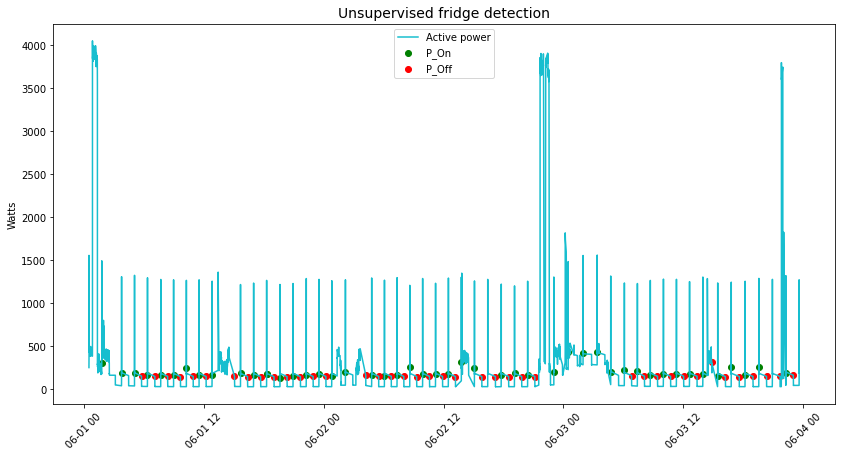

In [41]:
# plot results with events

fig, ax1 = plt.subplots(figsize=(14, 7.0))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
ax1.plot(df2.index, df2['pwrA'], '-', color='tab:cyan')
# ax1.plot(df2.index, df2['delta'], '-', color='tab:orange')
# ax1.plot(df2.index, df2['deltaoff'], '-', color='tab:green')
ax1.set_title('Unsupervised fridge detection', fontsize=14)
ax1.set_ylabel('Watts')
cl1 = df2['rule']>0
cl2 = df2['rule']<1
ax1.scatter(df2.index[cl1], df2['pwrA'][cl1], color='green') 
ax1.scatter(df2.index[cl2], df2['pwrA'][cl2], color='red') 
ax1.legend(['Active power','P_On','P_Off'])

In [43]:
onoff

,pwrA,deltaoff,fridge,rule,timedifON,timedifOFF
2022-06-01 01:46:36.900000+03:00,305.608917,0.000000,1.0,1.0,NaN,NaN
2022-06-01 03:45:37.100000+03:00,187.798355,0.000000,1.0,1.0,NaN,NaN
2022-06-01 05:03:22.550000+03:00,185.559464,0.000000,1.0,1.0,NaN,NaN
2022-06-01 05:45:26.550000+03:00,153.856735,118.321024,0.0,0.0,42.0,NaN
2022-06-01 06:21:17.900000+03:00,171.588776,0.000000,1.0,1.0,NaN,35.0
...,...,...,...,...,...,...
2022-06-03 19:34:08.600000+03:00,255.771149,0.000000,1.0,1.0,NaN,35.0
2022-06-03 20:20:12.600000+03:00,150.811844,119.064340,0.0,0.0,46.0,NaN
2022-06-03 21:41:32.650000+03:00,150.140167,118.285195,0.0,0.0,NaN,NaN
2022-06-03 22:16:19.600000+03:00,191.873138,0.000000,1.0,1.0,NaN,34.0
